In [1]:
# Imports and setup
import os
import warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

# Data Pipelining
# PyTorch DataLoader automatically shuffles the training data
data_dir_train = '../input/car-or-truck/train'
data_dir_valid = '../input/car-or-truck/valid'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(), # Converts to a tensor and scales to [0, 1]
])

ds_train_ = ImageFolder(root=data_dir_train, transform=transform)
ds_valid_ = ImageFolder(root=data_dir_valid, transform=transform)

ds_train = DataLoader(ds_train_, batch_size=64, shuffle=True)
ds_valid = DataLoader(ds_valid_, batch_size=64, shuffle=False)

# Check the number of files and classes loaded
print(f"Found {len(ds_train_.imgs)} files belonging to {len(ds_train_.classes)} classes.")
print(f"Found {len(ds_valid_.imgs)} files belonging to {len(ds_valid_.classes)} classes.")

# PyTorch uses a GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.
Using device: cuda


# Design a Convnet

In [2]:
# Define the CNN model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Block One
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Block Two
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Block Three
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Head
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 6), # Adjust the size based on input image dimensions and pooling
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(6, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.head(x)
        return x

model = ConvNet().to(device)
print(model)

ConvNet(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=6, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


# Compile

In [3]:
# Compile the model
optimizer = optim.Adam(model.parameters(), eps=0.01)
loss_fn = nn.BCELoss()

# Train the model

Epoch 1/50, Loss: 0.6840, Accuracy: 0.5593, Val Loss: 0.6765, Val Accuracy: 0.5785
Epoch 2/50, Loss: 0.6667, Accuracy: 0.5912, Val Loss: 0.6537, Val Accuracy: 0.6169
Epoch 3/50, Loss: 0.6579, Accuracy: 0.6084, Val Loss: 0.6591, Val Accuracy: 0.6177
Epoch 4/50, Loss: 0.6463, Accuracy: 0.6283, Val Loss: 0.6364, Val Accuracy: 0.6302
Epoch 5/50, Loss: 0.6392, Accuracy: 0.6387, Val Loss: 0.6313, Val Accuracy: 0.6434
Epoch 6/50, Loss: 0.6338, Accuracy: 0.6578, Val Loss: 0.6229, Val Accuracy: 0.6525
Epoch 7/50, Loss: 0.6258, Accuracy: 0.6592, Val Loss: 0.6318, Val Accuracy: 0.6498
Epoch 8/50, Loss: 0.6222, Accuracy: 0.6578, Val Loss: 0.6159, Val Accuracy: 0.6573
Epoch 9/50, Loss: 0.6167, Accuracy: 0.6668, Val Loss: 0.6069, Val Accuracy: 0.6688
Epoch 10/50, Loss: 0.6037, Accuracy: 0.6828, Val Loss: 0.6019, Val Accuracy: 0.6787
Epoch 11/50, Loss: 0.5990, Accuracy: 0.6887, Val Loss: 0.5923, Val Accuracy: 0.6884
Epoch 12/50, Loss: 0.5906, Accuracy: 0.6963, Val Loss: 0.6011, Val Accuracy: 0.6896
E

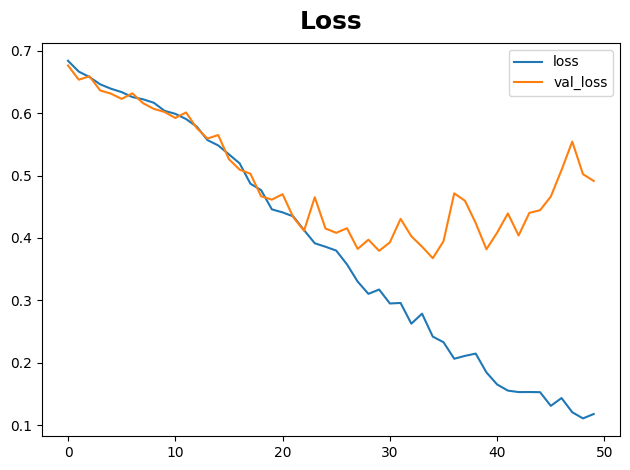

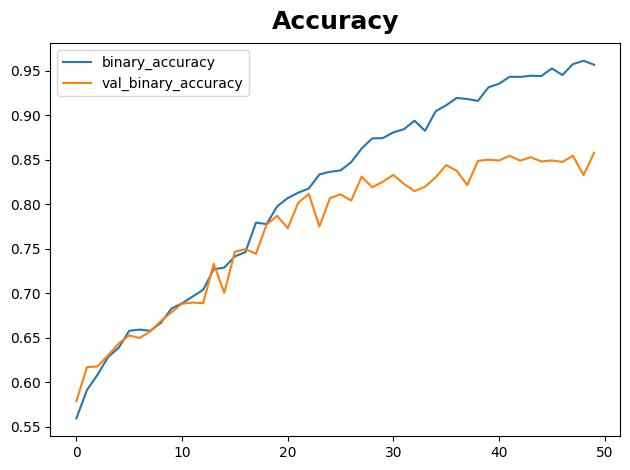

In [4]:
# Train the model
epochs = 50
history = {'loss': [], 'val_loss': [], 'binary_accuracy': [], 'val_binary_accuracy': []}

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(ds_train):
        inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / total_train
    train_accuracy = correct_train / total_train
    history['loss'].append(train_loss)
    history['binary_accuracy'].append(train_accuracy)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in ds_valid:
            inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(inputs)
            val_loss = loss_fn(outputs, labels)
            
            running_val_loss += val_loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    valid_loss = running_val_loss / total_val
    valid_accuracy = correct_val / total_val
    history['val_loss'].append(valid_loss)
    history['val_binary_accuracy'].append(valid_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Loss: {train_loss:.4f}, "
          f"Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {valid_loss:.4f}, "
          f"Val Accuracy: {valid_accuracy:.4f}")

# Plotting the training curves
import pandas as pd
history_frame = pd.DataFrame(history)
history_frame.loc[:, ['loss', 'val_loss']].plot(title="Loss")
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy");